In [1]:
# see document-32192 for details of what we do in this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
import scipy.io

%matplotlib inline

In [24]:
# available in mat: 'F','xact','yact','actIDs'
mat = scipy.io.loadmat('data/LSST_FEA_final.mat')
xact = mat['xact'].squeeze()
yact = mat['yact'].squeeze()
F = mat['F'].squeeze()
actIDs = mat['actIDs'].squeeze()

In [25]:
sum(F)

169687.87000000005

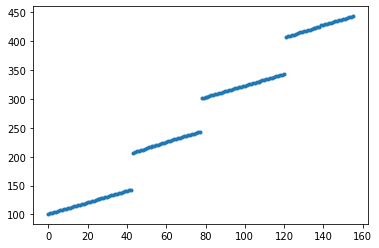

In [33]:
plt.plot(actIDs,'.')

In [11]:
actTypeFile = 'data/LS_CUP_ACTSTYLE_ID.xlsx'
df = pd.read_excel(actTypeFile)
#df.keys()
idx00 = ~np.isnan(np.float64(df['Unnamed: 8'][2:])) #actuator ID column

In [12]:
actType = df['Unnamed: 12'][2:][idx00]
cupType = df['Unnamed: 13'][2:][idx00]
puckType = df['Unnamed: 11'][2:][idx00]
orientType = df['Unnamed: 10'][2:][idx00]
nActuator = actType.shape[0]

In [13]:
nActuator

156

In [14]:
# subtraction: hardware that were removed after the 2014 testing
subtractF = np.zeros(nActuator)
# for each actuator
subtractF = subtractF + 50.8023*9.8/(156+4) #112 lbs is 50.8023 kilograms
# for Quads, this needs to be doubled, so, add again.
idx = puckType =='Quad Puck'
subtractF[idx] = subtractF[idx] + 50.8023*9.8/(156+4)
print('Removed 160 interface plates (each Quad had 2 plates), total is 112lb, according to Steve West')

# additional plates that was removed.
subtractF[idx] = subtractF[idx] + 0.51355*9.8
print('Additional plates removed from %d Quads'%sum(idx))
print('\t each 0.51355 kg')
idx = puckType =='Triple Puck'
subtractF[idx] = subtractF[idx] + 0.51355*9.8
print('Additional plates removed from %d Triples'%sum(idx))
print('\t each 0.51355 kg')

# add up our subtraction by hand (in kg)
subtractFsum = (50.8023 + 0.51355 * (114 +4))*9.8
print(subtractFsum, ' == ?? == ' , sum(subtractF))

Removed 160 interface plates (each Quad had 2 plates), total is 112lb, according to Steve West
Additional plates removed from 4 Quads
	 each 0.51355 kg
Additional plates removed from 114 Triples
	 each 0.51355 kg
1091.73176  == ?? ==  1091.7317600000006


In [34]:
# add LSST hardware, everything except DAAs here
mSAA2 = 0.97465 #kg
mSAA1 = 0.78617  #kg
mIC1 = 1.23  #kg
mIC2 = 1.85  #kg
mIP = 103.41e-3   #kg, each, for interface plates
addFz0 = np.zeros(nActuator)

idx = actType == 'SAA-1'
addFz0[idx] = addFz0[idx] + mSAA1*9.8
print('Added %d SAA-1 actuators, each weigh %.5f kg'%(sum(idx), mSAA1))

idx = actType ==  'SAA-2'
addFz0[idx] = addFz0[idx] + mSAA2*9.8
print('Added %d SAA-2 actuators, each weigh %.5f kg'%(sum(idx), mSAA2))

idx = cupType == 'small flange'
addFz0[idx] = addFz0[idx] +mIC1*9.8
print('Added %d interface cup - 1, each weigh %.5f kg'%(sum(idx), mIC1))

idx = cupType == 'large flange'
addFz0[idx] = addFz0[idx] +mIC2*9.8
print('Added %d interface cup - 2, each weigh %.5f kg'%(sum(idx), mIC2))

idx = puckType == 'Triple Puck'
addFz0[idx] = addFz0[idx] +mIP*9.8*3
print('Added %d interface plates on triple puck actuators, each weigh %.5f kg'%(sum(idx)*3, mIP))

idx = puckType == 'Quad Puck'
addFz0[idx] = addFz0[idx] +mIP*9.8*4
print('Added %d interface plates on quad puck actuators, each weigh %.5f kg'%(sum(idx)*4, mIP))

#ID 238 is a triple puck, but was modified to have 4 interface plates
idx = actIDs ==238
addFz0[idx] = addFz0[idx] +mIP*9.8*1

print('Modified %d triple puck actuator to have 4 interface plates, each interface plate weight %.5f kg'%(1,mIP))
addFz0sum = (0.97465*6+0.78617*38+1.23*114+1.85*4+0.10341*(114*3+4*4+1))*9.8
print(addFz0sum, ' == ?? == ', sum(addFz0))

Added 38 SAA-1 actuators, each weigh 0.78617 kg
Added 6 SAA-2 actuators, each weigh 0.97465 kg
Added 114 interface cup - 1, each weigh 1.23000 kg
Added 4 interface cup - 2, each weigh 1.85000 kg
Added 342 interface plates on triple puck actuators, each weigh 0.10341 kg
Added 16 interface plates on quad puck actuators, each weigh 0.10341 kg
Modified 1 triple puck actuator to have 4 interface plates, each interface plate weight 0.10341 kg
2160.5721900000003  == ?? ==  2160.5721900000035


In [35]:
# Now the DAAs
def fc2fyz(fc1, fc2):
    fy = fc2*np.cos(np.pi/4)
    fz = fc2*np.cos(np.pi/4)+fc1
    return fy, fz
Wfork = 5.7
alpha = 0.4385
W = 38.0
WU = 3.4
fc1 = alpha*W + WU + Wfork  #Eq (4) in technical note
fc2 = (Wfork - alpha*W)/np.sqrt(2)  #Eq (6) in technical note
FyDAA, FzDAA = fc2fyz(fc1, fc2)
#FzDAA = (3*Wfork + alpha *W)/2 + WU
#FyDAA = (Wfork - alpha*W)/2
print('%.1f, %.1f %.1f %.1f'%(fc1, fc2, FyDAA, FzDAA))

25.8, -7.8 -5.5 20.3


In [36]:
#
addFz = np.zeros(nActuator)
idx = actType == 'DAA'
addFz[idx] = FzDAA
print('Added Fz = %.1f N for each of the %d DAA actuators'%(FzDAA, sum(idx)))

addFy = np.zeros(nActuator)
idx = orientType == '+Y LATERAL'
addFy[idx] = FyDAA
print('Added Fy = %.1f N for each of the %d DAA/+Y LATERAL actuators'%(FyDAA, sum(idx)))
idx = orientType == '-Y LATERAL'
addFy[idx] = - FyDAA
print('Added Fy = %.1f N for each of the %d DAA/-Y LATERAL actuators'%(-FyDAA, sum(idx)))

# the crosslaterals squeeze the mirror when they all push
addFx = np.zeros(nActuator)
idx = (orientType == 'CROSSLATERAL') & (xact > 0)
addFx[idx] = -FyDAA
print('Added Fx = %.1f N for each of the %d CROSSLATERAL actuators with positive x'%(-FyDAA, sum(idx)))
idx = (orientType == 'CROSSLATERAL') & (xact < 0)
addFx[idx] = FyDAA
print('Added Fx = %.1f N for each of the %d CROSSLATERAL actuators with negative x'%(FyDAA, sum(idx)))

Added Fz = 20.3 N for each of the 112 DAA actuators
Added Fy = -5.5 N for each of the 96 DAA/+Y LATERAL actuators
Added Fy = 5.5 N for each of the 4 DAA/-Y LATERAL actuators
Added Fx = 5.5 N for each of the 6 CROSSLATERAL actuators with positive x
Added Fx = -5.5 N for each of the 6 CROSSLATERAL actuators with negative x


In [38]:
knownF = np.zeros((nActuator, 3))
knownF[:,2] = F 
#knownF[:,2] -= subtractF
knownF[:,2] += addFz0

knownF[:,2] += addFz
knownF[:,0] = addFx
knownF[:,1] = addFy
knownF0 = knownF.copy() #knownF0: without scaling, our best knowledge

In [39]:
sum(addFz)+sum(addFz0)

4432.100190000008

In [41]:
quadsID = [126, 113, 313, 326]
idx1=int(np.where(actIDs == quadsID[0])[0][0])
idx2=int(np.where(actIDs == quadsID[1])[0][0])
idx3=int(np.where(actIDs == quadsID[2])[0][0])
idx4=int(np.where(actIDs == quadsID[3])[0][0])
print('FEA F: %.0f %.0f %.0f %.0f'%(F[idx1], F[idx2], F[idx3], F[idx4]))
print('knownF: %.0f %.0f %.0f %.0f'%(knownF[idx1,2], knownF[idx2,2], knownF[idx3,2], knownF[idx4,2]))

FEA F: 1849 1389 1387 1852
knownF: 1892 1432 1430 1894


In [42]:
ChrisFtot = 172741.583  # in Newtons. from Chris.
print('sum of polishing forces: %.0f N'%(sum(F) ))
print('sum of all the known forces: %.0f N'%(sum(knownF0[:, 2]) ))
print('This is how much we are missing: %.0f N'%(ChrisFtot - sum(knownF0[:, 2])))
print('note: in Sec3.2InitialForces.ipynb, we missed 3836 N')
scalef = ChrisFtot/sum(knownF0[:, 2])

sum of polishing forces: 169688 N
sum of all the known forces: 174120 N
This is how much we are missing: -1378 N
note: in Sec3.2InitialForces.ipynb, we missed 3836 N


In [16]:
knownF[:, 2] = knownF0[:, 2]*scalef
print('Now the total Fz = %.0f N. Chris gave total mirror weight = %.0f N'%(sum(knownF[:,2]), ChrisFtot))

Now the total Fz = 172742 N. Chris gave total mirror weight = 172742 N


In [17]:
knownF[:, 2] -= staticForce

In [26]:
aa0 = np.transpose(np.vstack((actIDsorted, np.transpose(knownF))))
print(aa0)
pd.DataFrame(aa0).to_csv("data/sec4.3Forces.csv", header=None, index=None)

[[ 101.            0.            0.          704.9228784 ]
 [ 102.            0.           -5.4815      911.9579515 ]
 [ 103.            0.           -5.4815     1016.20388937]
 [ 104.            0.           -5.4815     1262.25334935]
 [ 105.            0.           -5.4815     1170.37342088]
 [ 106.            0.            0.         1397.20307368]
 [ 107.            0.            0.          737.31328136]
 [ 108.            0.           -5.4815      889.06650197]
 [ 109.            0.           -5.4815      955.26229135]
 [ 110.            0.           -5.4815     1196.75470857]
 [ 111.            0.           -5.4815     1264.29401878]
 [ 112.            5.4815        0.         1343.39724247]
 [ 113.            0.           -5.4815     1429.58634794]
 [ 114.            0.           -5.4815      836.47431828]
 [ 115.            0.           -5.4815      972.48547967]
 [ 116.            0.           -5.4815     1118.14232564]
 [ 117.            0.           -5.4815     1170.7167979

In [18]:
t=np.arange(91)
tp = np.pi*t/180
fc1=(alpha*W+WU+Wfork)*np.cos(tp)-(2*alpha*W+WU)*np.sin(tp)
fc2=(Wfork+3*alpha*W+2*WU)/np.sqrt(2)*np.sin(tp) + (Wfork - alpha*W)/np.sqrt(2)*np.cos(tp)
fy, fz = fc2fyz(fc1, fc2)

Text(0, 0.5, 'force (Newton)')

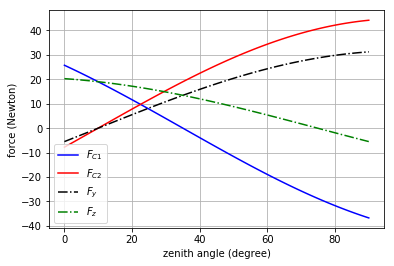

In [136]:
plt.plot(t, fc1, '-b', label='$F_{C1}$')
plt.plot(t, fc2, '-r', label='$F_{C2}$')
plt.plot(t, fy, '-.k', label='$F_y$')
plt.plot(t, fz, '-.g', label='$F_z$')
plt.legend(loc='lower left',  )
plt.grid()
plt.xlabel('zenith angle (degree)')
plt.ylabel('force (Newton)')

### Make this 3D matrix, for use as part of LUT.
1st dimension: zenith angle, in 5 deg increment: 0, 5, 10, ..., 90 degrees
2nd dimension: actuators, with ID numbers in ascending order
3rd dimension: actuator ID, Fx, Fy, Fz

In [76]:
aa = np.zeros(( int(90/5)+1, nActuator,4))
t = np.linspace(0,90,int(90/5)+1)
tp = np.pi*t/180
fc1=(alpha*W+WU+Wfork)*np.cos(tp)-(2*alpha*W+WU)*np.sin(tp)
fc2=(Wfork+3*alpha*W+2*WU)/np.sqrt(2)*np.sin(tp) + (Wfork - alpha*W)/np.sqrt(2)*np.cos(tp)
fy, fz = fc2fyz(fc1, fc2)
for i in range(len(t)): #for each zenith angle
    aa[i,:,0] = actIDsorted
    idx = (orientType == 'CROSSLATERAL') & (xact > 0)
    #aa[i,idx,1] = -fy[i] #no, these are perpendicular to Gravity, they just go to zero gradually
    aa[i,idx,1] = -fy[0]*np.cos(tp[i])
    idx = (orientType == 'CROSSLATERAL') & (xact < 0)
    #aa[i,idx,1] = fy[i] #no, these are perpendicular to Gravity, they just go to zero gradually
    aa[i,idx,1] = fy[0] * np.cos(tp[i])
    idx = orientType == '+Y LATERAL'
    aa[i,idx,2] = fy[i]
    idx = orientType == '-Y LATERAL'
    aa[i,idx,2] = -fy[i]
    idx = actType == 'DAA'
    aa[i,idx,3] = fz[i]

In [77]:
#check the 3D array against aa0 (for zenith only)
aa[0,:,:] - aa0

array([[    0.        ,     0.        ,     0.        ,  -704.9228784 ],
       [    0.        ,     0.        ,     0.        ,  -891.6764515 ],
       [    0.        ,     0.        ,     0.        ,  -995.92238937],
       [    0.        ,     0.        ,     0.        , -1241.97184935],
       [    0.        ,     0.        ,     0.        , -1150.09192088],
       [    0.        ,     0.        ,     0.        , -1397.20307368],
       [    0.        ,     0.        ,     0.        ,  -737.31328136],
       [    0.        ,     0.        ,     0.        ,  -868.78500197],
       [    0.        ,     0.        ,     0.        ,  -934.98079135],
       [    0.        ,     0.        ,     0.        , -1176.47320857],
       [    0.        ,     0.        ,     0.        , -1244.01251878],
       [    0.        ,     0.        ,     0.        , -1323.11574247],
       [    0.        ,     0.        ,     0.        , -1409.30484794],
       [    0.        ,     0.        ,     0.     

In [78]:
with open('data/fxfyfzDAAs.yaml', "w") as yamlFile:
    yaml.safe_dump(aa.tolist(), stream=yamlFile, default_flow_style=None)

In [67]:
#if we set fc2 to zero, the DAA will have to be tilted to stay in balance. What is that angle?
# putting more weight on the top is just like increasing WU
# Let's make WU a variable - WUV
WUV = np.arange(2000)
aa = alpha*W - Wfork
bb = Wfork+3*alpha*W+2*(WU + WUV)
theta = np.arctan(aa/bb)
shiftmm = (139.52+178.68)*theta

For 1000N of force, the angle is 0.3 degree, the shift is 1.7 mm
This is far from big enough to explain the missing mass, because [1 - cos(0.3 deg)] = 0.00001410
As a reference: [1 - cos(10.0 deg)] = 0.01519225


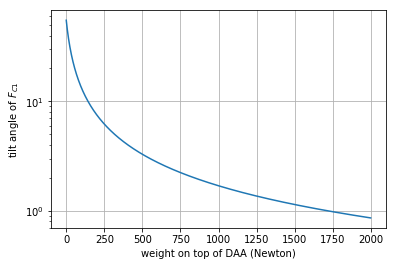

In [68]:
plt.semilogy(WUV, shiftmm)
plt.grid()
plt.xlabel('weight on top of DAA (Newton)')
plt.ylabel('tilt angle of $F_{C1}$')
print('For 1000N of force, the angle is %.1f degree, the shift is %.1f mm'%(theta[1001]/np.pi*180,shiftmm[1001]))
print('This is far from big enough to explain the missing mass, because [1 - cos(%.1f deg)] = %.8f'%(theta[1001]/np.pi*180, 1-np.cos(theta[1001])))
print('As a reference: [1 - cos(%.1f deg)] = %.8f'%(10, 1-np.cos(10/180*np.pi)))